In [1]:
from sklearn.ensemble import IsolationForest 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import VarianceThreshold

from pyod.models.knn import KNN 

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

sns.set()

## Кластеризация

### K-means

Сгенерируем произвольные данные

In [2]:
data = np.array([[np.random.rand(), np.random.rand()] for _ in range(500)])

C:\Users\Евгений\AppData\Local\Temp\ipykernel_8508\997464193.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


<Axes: xlabel='f1', ylabel='f2'>

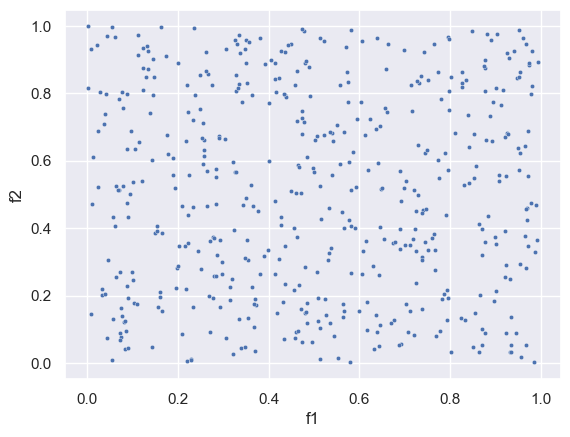

In [3]:
sns.scatterplot(
    data=pd.DataFrame(data, columns=['f1', 'f2']), 
    x='f1',
    y='f2',
    palette='deep',
    s=10
)

Обучим метод K-средних

In [4]:
# Обучение модели
model = KMeans(3, random_state=12)
model.fit(data)

print("Центроиды кластеров:")
print(model.cluster_centers_)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Центроиды кластеров:
[[0.80112031 0.66887084]
 [0.4638757  0.21093125]
 [0.25888769 0.74528137]]


<Axes: xlabel='f1', ylabel='f2'>

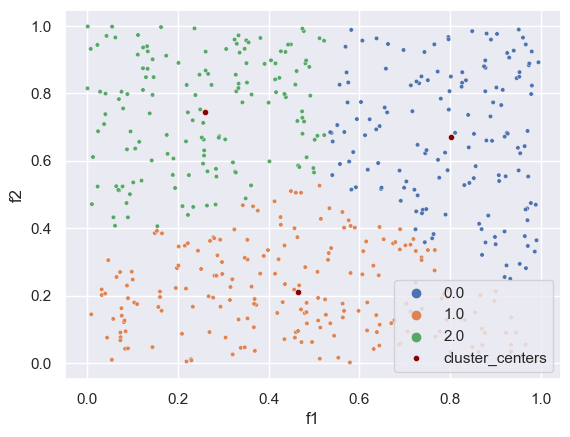

In [5]:
# разметка моделью
sns.scatterplot(
    data=pd.DataFrame(np.hstack([data, np.array([model.labels_]).T]), columns=['f1', 'f2', 'label']), 
    x='f1',
    y='f2',
    hue='label', 
    palette='deep',
    s=10
)
sns.scatterplot(
    pd.DataFrame(model.cluster_centers_, columns=['f1', 'f2']), 
    color='darkred', 
    x='f1',
    y='f2',
    s=20,
    label='cluster_centers'
)

In [6]:
# оценка качества модели
print("Целевая функция:")
print(model.inertia_)

Целевая функция:
32.612762545217585


In [7]:
# попробуем иначе разместить центры кластеров
model = KMeans(n_clusters=3, random_state=0, init=[[0.5, 0], [1, 1], [0, 1]])
model.fit(data)

print("Целевая функция модели с начальными центроидами:")
print(model.inertia_)

Целевая функция модели с начальными центроидами:
32.61175538105759


C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


<Axes: xlabel='f1', ylabel='f2'>

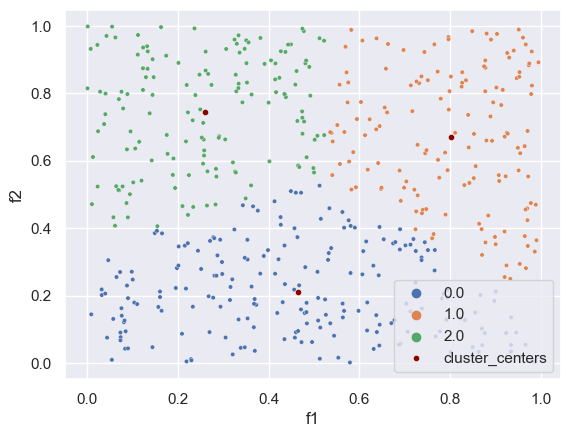

In [8]:
# разметка моделью
sns.scatterplot(
    data=pd.DataFrame(np.hstack([data, np.array([model.labels_]).T]), columns=['f1', 'f2', 'label']), 
    x='f1',
    y='f2',
    hue='label', 
    palette='deep',
    s=10
)
sns.scatterplot(
    pd.DataFrame(model.cluster_centers_, columns=['f1', 'f2']), 
    color='darkred', 
    x='f1',
    y='f2',
    s=20,
    label='cluster_centers'
)

### Визуализация

Сгенерируем произвольные данные бОльшей размерности.

In [9]:
varied = datasets.make_blobs(
    n_samples=500, cluster_std=[1.0, 2.5, 0.5], random_state=123, n_features=3
)
data_2 = pd.DataFrame(varied[0], columns=['f1', 'f2', 'f3'])
data_2.head()

,f1,f2,f3
0,9.090242,3.468917,0.741360
1,-1.306870,5.814657,-0.546549
2,3.840042,-3.223516,-6.204020
3,3.061613,0.678294,-3.473177
4,2.081576,6.415268,-1.593688


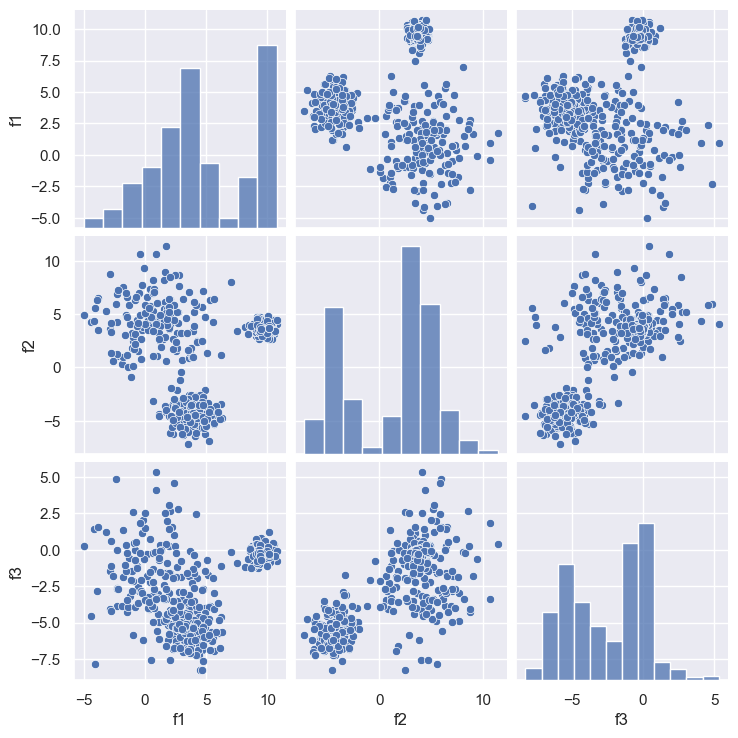

In [10]:
sns.pairplot(data_2, diag_kind='hist'); 

In [11]:
# построим кластеризацию
model = KMeans(n_clusters=3, random_state=45)
model.fit(data_2)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


KMeans(n_clusters=3, random_state=45)

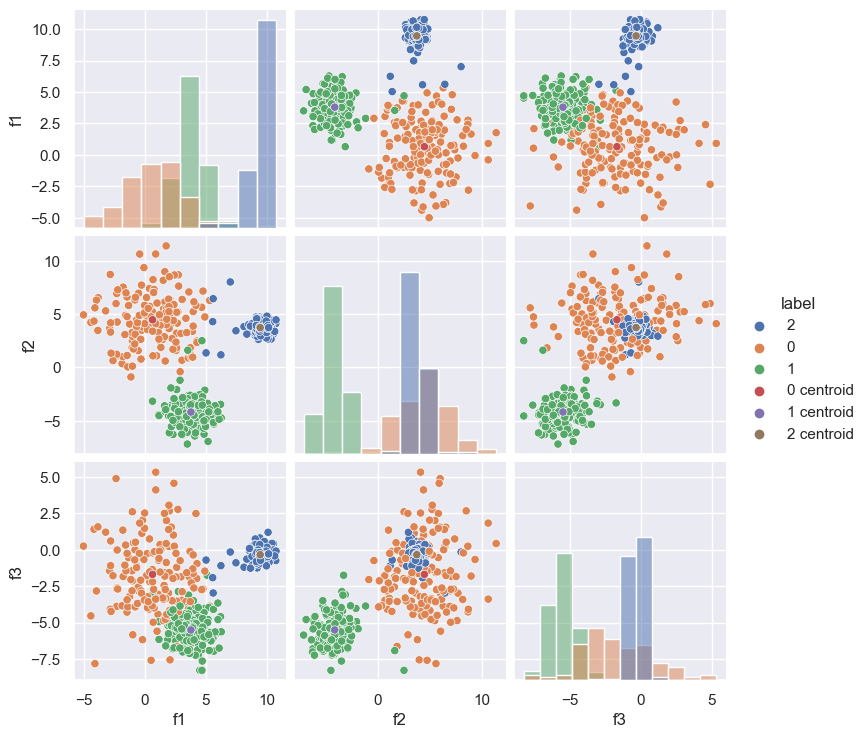

In [12]:
# визуализируем результаты
centroids = pd.DataFrame(model.cluster_centers_, columns=['f1', 'f2', 'f3'])
# Добавление столбца с номером кластера
data_2_w_label = data_2.copy()
data_2_w_label['label'] = model.labels_.astype(str)
centroids['label'] = ['0 centroid', '1 centroid', '2 centroid']

data_all = pd.concat([data_2_w_label, centroids], ignore_index=True)

# Построение графика
pairgrid = sns.pairplot(data_all, hue='label', diag_kind='hist') 

### Метод локтя

In [13]:
distortion = []
K = range(1, 10)
for k in tqdm(K):
    model = KMeans(n_clusters=k, random_state=4)
    model.fit(data_2)
    distortion.append(model.inertia_) 

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
 11%|█████████▎                                                                          | 1/9 [00:00<00:02,  3.34it/s]C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:

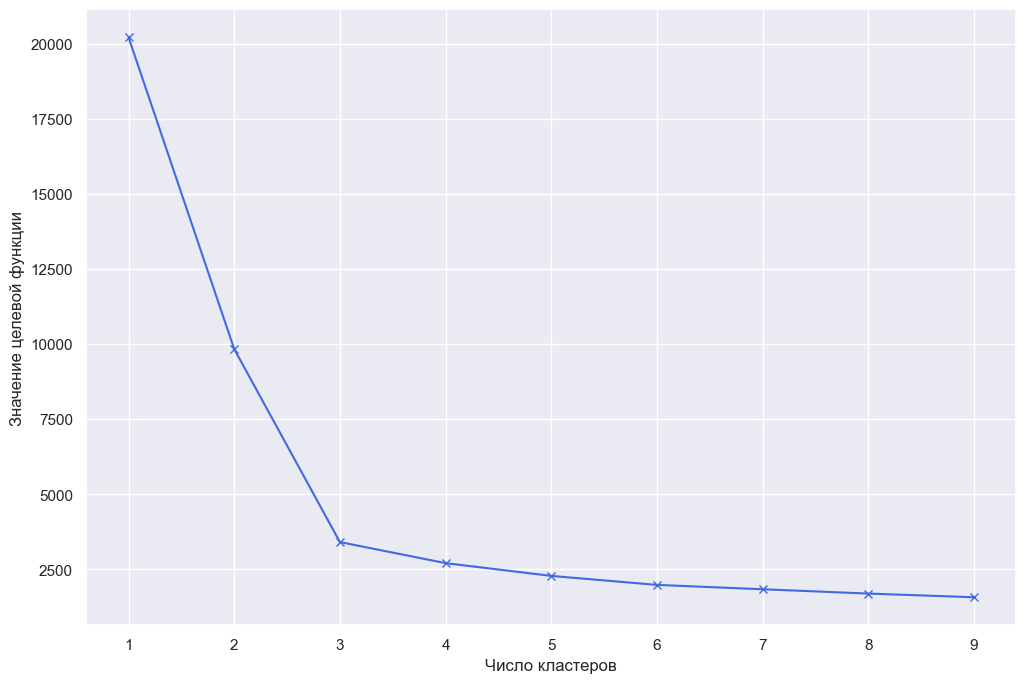

In [14]:
plt.figure(figsize=(12, 8))
plt.plot(K, distortion, c='royalblue', marker='x')
plt.xlabel('Число кластеров')
plt.ylabel('Значение целевой функции')
plt.show()

## Поиск аномалий

### Диаграмма размаха

In [15]:
data_titanic = pd.read_csv('titanic.csv')
data_titanic.head(4)

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000


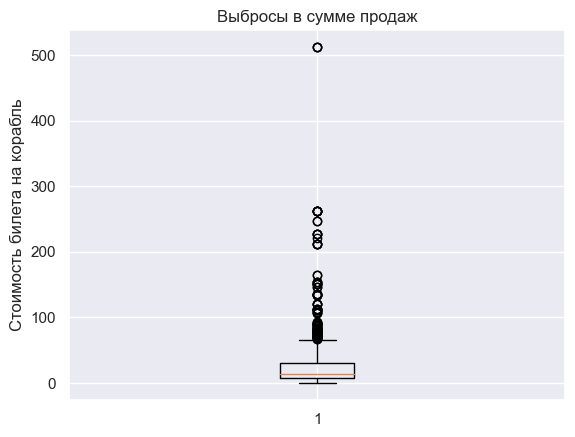

In [16]:
plt.boxplot(data_titanic['Fare'].values)
plt.ylabel('Стоимость билета на корабль')
plt.title("Выбросы в сумме продаж")
plt.show() 

Диаграмма даёт информацию обо всех выбросах. Она хранится в записи "fliers"внутри объекта boxplot. Вызовом функции get_data() из объектов получим числа. Нужные значения отделены индексами.

Выбросов в стоимостях билетов:  116


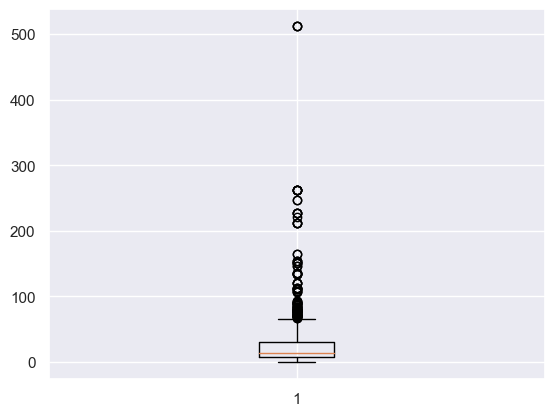

In [17]:
boxplot = plt.boxplot(data_titanic['Fare'].values)
outliers_bp = list(boxplot["fliers"][0].get_data()[1])
print("Выбросов в стоимостях билетов: ", len(outliers_bp)) 

Рассчитаем выбросы самостоятельно

In [18]:
l = np.quantile(data_titanic['Fare'], 0.25)
r = np.quantile(data_titanic['Fare'], 0.75)
iqr = r - l

print(data_titanic['Fare'].shape[0] - (data_titanic['Fare'].apply(lambda f: l - 1.5 * iqr < f < r + 1.5 * iqr)).sum())

116


In [19]:
print('Верхняя граница усов:', r + 1.5 * iqr)

Верхняя граница усов: 65.95625


### Изоляционный лес

Пропишем количество деревьев в параметре n_estimators. Чем их больше, тем точнее результаты:

In [20]:
isolation_forest = IsolationForest(n_estimators=50, random_state=14, contamination=0.05) 

Выбор аномалий по одному признаку не даст представления обо всём датасете. Изоляционный лес найдёт выбросы по нескольким признакам. 
Например, объединим данные о стоимости билета и возрасте пассажира. 

In [21]:
data_for_iso = data_titanic[['Fare', 'Age']] 

Функцией fit_predict() можно сразу обучить модель и получить классификацию.

In [22]:
isolation_forest_predictions = (isolation_forest.fit_predict(data_for_iso) == -1)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [23]:
outliers_iso_tree = data_for_iso[isolation_forest_predictions]

print("Количество аномалий: ", len(outliers_iso_tree))

Количество аномалий:  45


### KNN

Функция predict обученной модели KNN вернёт список, где «1» означает аномалию, а «0» — её отсутствие.

In [24]:
data_for_iso_scaled = StandardScaler().fit_transform(data_for_iso)

In [25]:
knn_model = KNN(contamination=0.05)

knn_model.fit(data_for_iso_scaled)
knn_prediction = knn_model.predict(data_for_iso_scaled) == 1
outliers_knn = data_for_iso[knn_prediction]
print("Количество аномалий (KNN): ", len(outliers_knn))

Количество аномалий (KNN):  36


Сравним результаты

In [26]:
map_color = {0: 'lightblue', 1: 'darkgreen'}

C:\Users\Евгений\AppData\Local\Temp\ipykernel_8508\4105529908.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


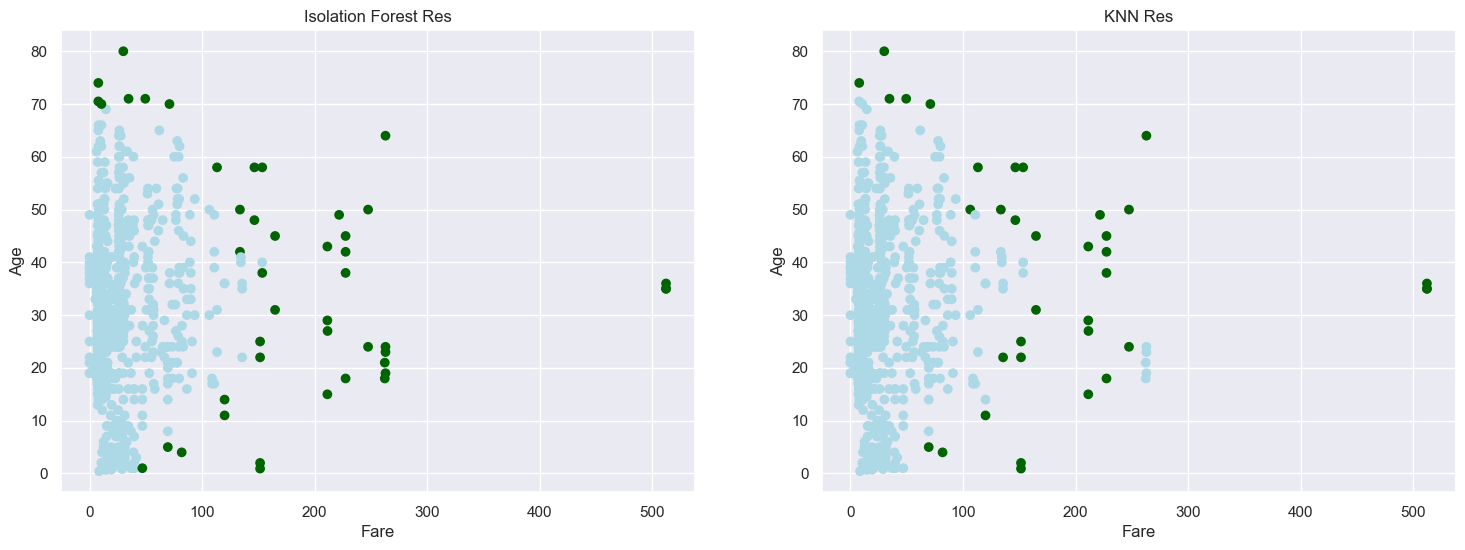

In [27]:
fig, ax = plt.subplots(1, 2, figsize=[18, 6])

for i, res in enumerate(
    [(isolation_forest_predictions, 'Isolation Forest'), 
     (knn_prediction, 'KNN')
    ]
):
    ax[i].scatter(data_for_iso['Fare'], data_for_iso['Age'], color=(pd.Series(res[0]) * 1).map(map_color))
    ax[i].set_title(f'{res[1]} Res')
    ax[i].set_xlabel('Fare')
    ax[i].set_ylabel('Age')

fig.show()

## Уменьшение размерности

### Отбор признаков

Попрактикуемся в отборе признаков на синтетических данных

In [28]:
x_data_generated, y_data_generated = datasets.make_classification(n_samples=100, n_features=20, scale=1, random_state=98765)

In [29]:
model = LogisticRegressionCV(random_state=12)
model.fit(x_data_generated, y_data_generated)

LogisticRegressionCV(random_state=12)

In [30]:
model.scores_[1].mean()

0.835

Выберем признаки на основе матрицы корреляций

In [31]:
X = np.column_stack((x_data_generated, y_data_generated))

<Axes: >

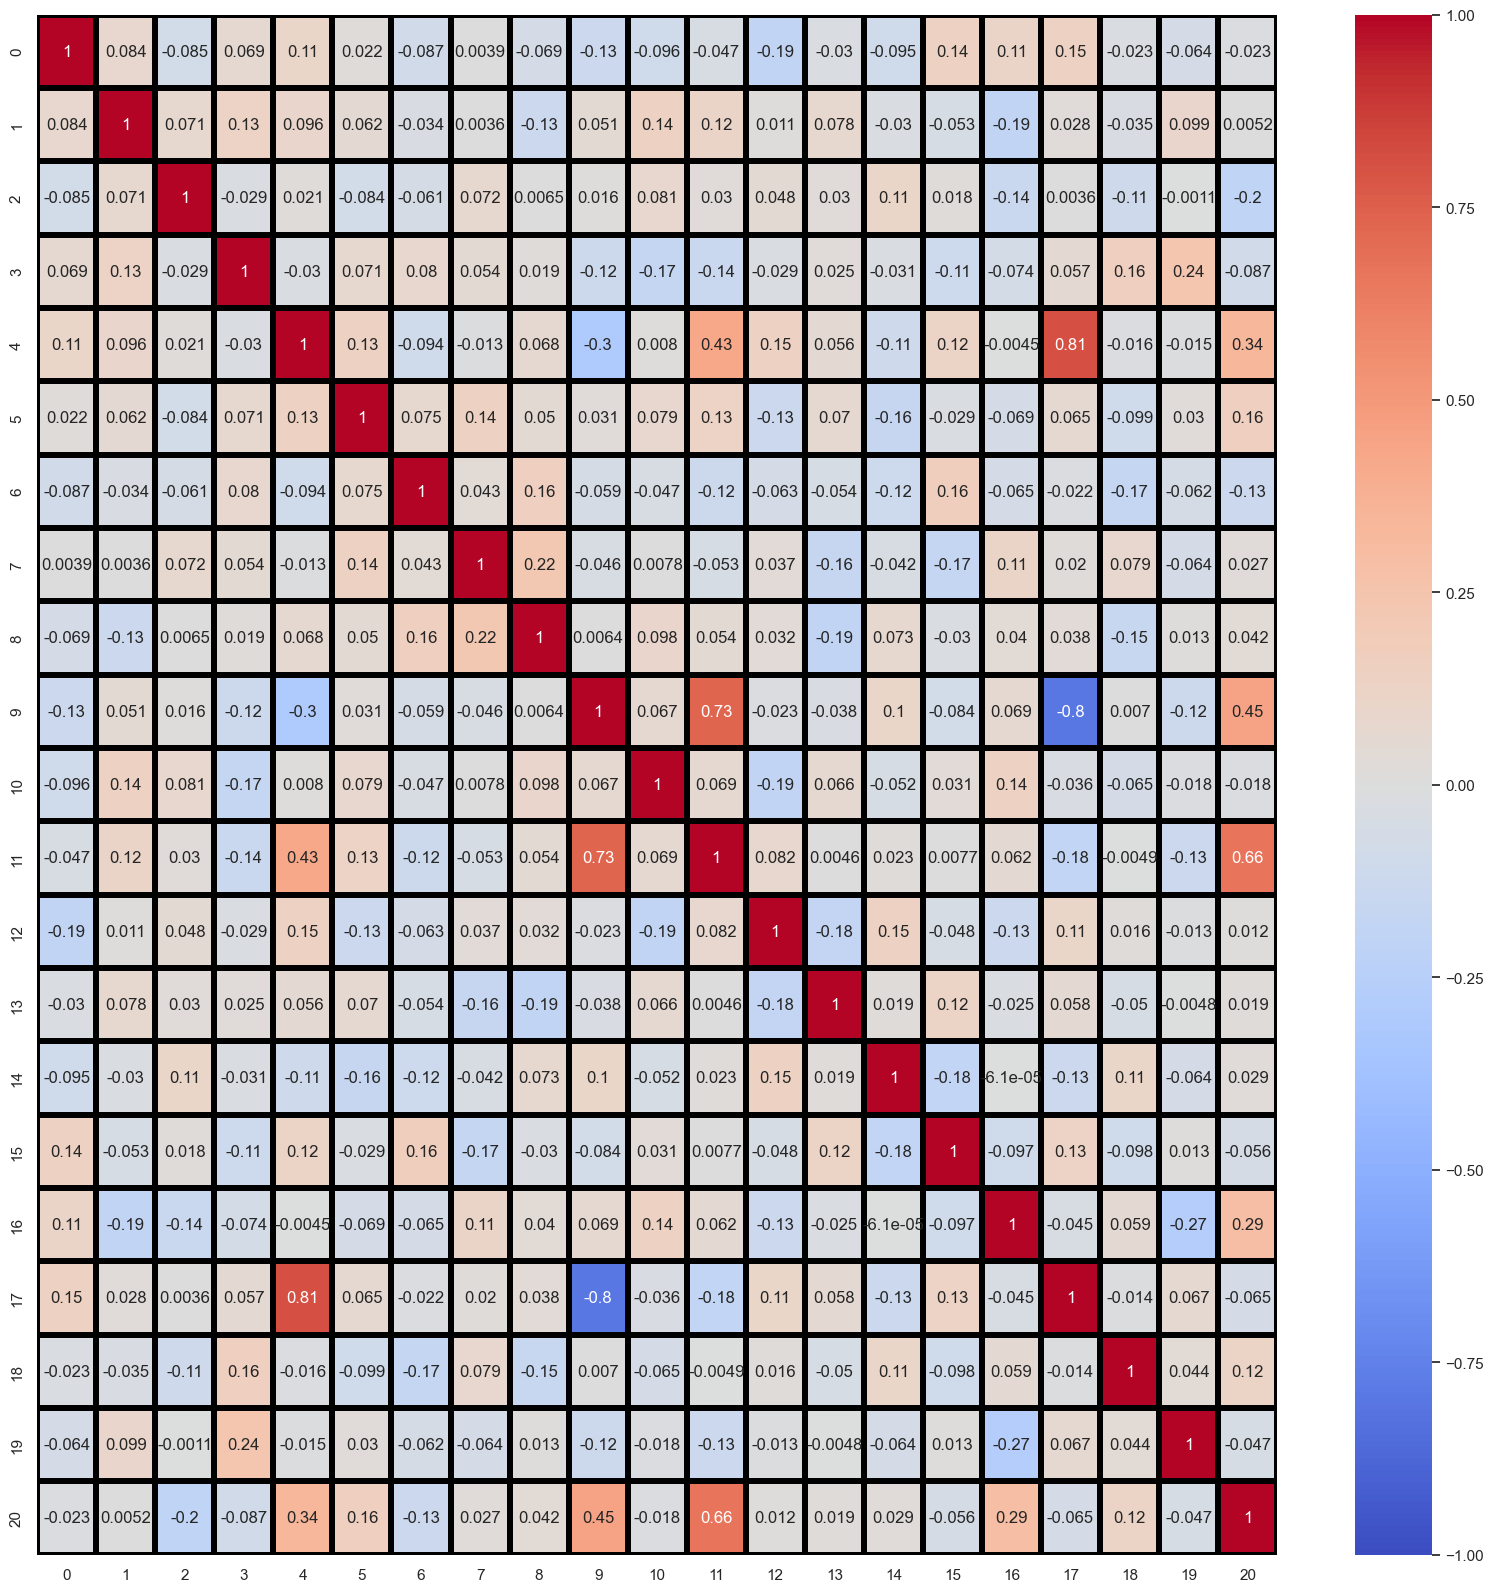

In [32]:
corr_matrix = pd.DataFrame(X).corr()
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(
    corr_matrix, 
    annot = True, 
    vmin=-1, 
    vmax=1, 
    center=0, 
    cmap= 'coolwarm', 
    linewidths=3,
    linecolor='black', 
    ax=ax
)

4-17, 9-11, 9-17, 11-20

In [33]:
df = pd.DataFrame(x_data_generated)
df = df.loc[:, (df.columns != 4) & (df.columns != 9)]
df.shape

(100, 18)

Удалим низковариативные признаки

In [34]:
var = VarianceThreshold(threshold=1)
df2 = var.fit_transform(df)
df2.shape

(100, 9)

In [35]:
model = LogisticRegressionCV(random_state=12)
model.fit(df2, y_data_generated)
model.scores_[1].mean()

0.85

### Метод главных компонент

Загрузим игрушечный датасет из sklearn про ирисы

In [36]:
iris = datasets.load_iris(as_frame=True)
features = iris['data']
target = iris['target']
display(features.head())
features.shape

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


(150, 4)

Изучим распределение ирисов разного типа по признакам, а также связи между этими признаками

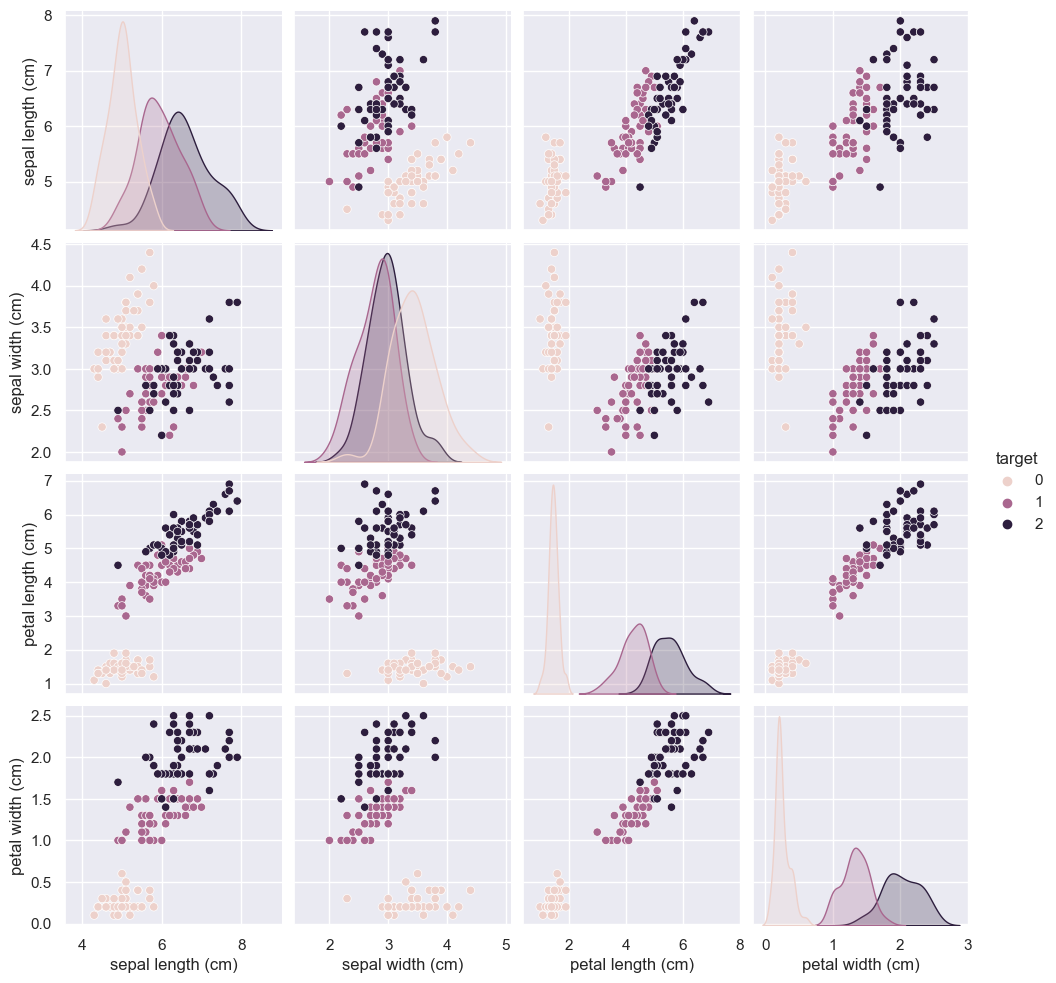

In [37]:
sns.pairplot(iris['frame'], hue='target', )

Для начала отмасштабируем выборку.

In [38]:
features_norm = StandardScaler().fit_transform(features.values)

In [39]:
sum([features_norm[:, i].var() for i in range(4)])

4.0

Подберем оптимальное количество компонент, объясняющих достаточно дисперсии в исходных данных

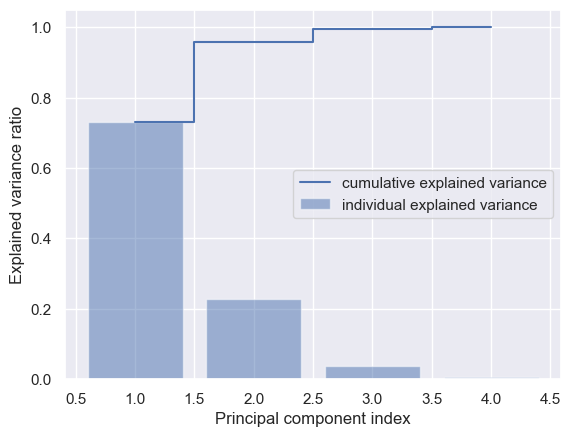

In [40]:
pca = PCA(n_components = 4)
pca.fit(features_norm)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(1, 5), var_exp, alpha=0.5,
        align='center', label='individual explained variance')
plt.step(range(1, 5), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

Уменьшим количество признаков до двух

In [41]:
pca = PCA(n_components = 2)
features_reduced = pca.fit_transform(features_norm)

Изучим, как они были составлены

In [42]:
pd.DataFrame(pca.components_, columns=features.columns)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.521066,-0.269347,0.580413,0.564857
1,0.377418,0.923296,0.024492,0.066942


In [43]:
pd.DataFrame(features_norm).corr()

,0,1,2,3
0,1.000000,-0.117570,0.871754,0.817941
1,-0.117570,1.000000,-0.428440,-0.366126
2,0.871754,-0.428440,1.000000,0.962865
3,0.817941,-0.366126,0.962865,1.000000


Убедимся, что новые векторы полностью декоррелированы

In [44]:
pd.DataFrame(features_reduced).corr()

,0,1
0,1.000000e+00,3.954455e-16
1,3.954455e-16,1.000000e+00


Насколько хорошо разделимы данные по новым компонентам?

In [45]:
map_color[2] = 'coral'

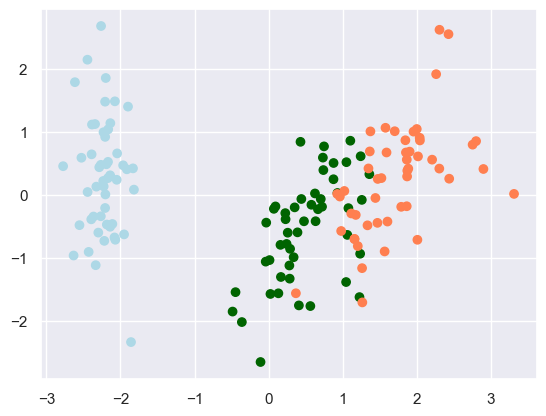

In [46]:
plt.scatter(features_reduced[:, 0], features_reduced[:, 1], color=target.map(map_color))